In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Чтение из XML

In [3]:
from xml.dom import minidom

#‭ ‬обработка файла xml по имени
mydoc = minidom.parse("updated.xml")

items = mydoc.getElementsByTagName("Article")

#‭ ‬общее количество элементов
print(len(items))

836


In [4]:
from lxml import etree
def parseXML(xmlFile):
    with open(xmlFile) as fobj:
        xml = fobj.read()
    
    root = etree.fromstring(xml)
 
    article_dict = {}
    articles = []
    for article in root.getchildren():
        for elem in article.getchildren():
            if not elem.text:
                text = "None"
            else:
                text = elem.text
            article_dict[elem.tag] = text
        
        if article.tag == "Article":
            articles.append(article_dict)
            article_dict = {}
    
    return articles

In [5]:
articles = parseXML("updated.xml")
articles = articles[2:]

# Формируем DataFrame

In [6]:
dataframe = pd.DataFrame.from_dict(articles)

In [7]:
dataframe = dataframe[["genre", "text"]]

In [8]:
dataframe = dataframe.dropna()

In [9]:
for i in np.unique(dataframe.genre):
    print(len(dataframe[dataframe.genre == i]))

99
74
403
72
139


# Выравниваем классы

In [10]:
dataframe_auto = dataframe[dataframe.genre == "AUTO"][:72]
dataframe_winter = dataframe[dataframe.genre == "WINTER"][:72]
dataframe_world = dataframe[dataframe.genre == "WORLD"][:72]
dataframe_town = dataframe[dataframe.genre == "TOWN"][:72]
dataframe_accidents = dataframe[dataframe.genre == "ACCIDENTS"][:72]

In [11]:
frames = [dataframe_auto, dataframe_winter, dataframe_world, dataframe_town, dataframe_accidents]
df = pd.concat(frames)

In [12]:
for i in np.unique(df.genre):
    print(len(df[df.genre == i]))

72
72
72
72
72


In [13]:
df

,genre,text
0,AUTO,"Мы разобрались, можно ли купить дешёвую страхо..."
1,AUTO,Недорогой 5-метровый минивэн везёт кучу вещей ...
2,AUTO,"Реагируя на фотографию Mazda 6, которую я выло..."
3,AUTO,"Правы были те, кто не ждал отката цен, а покуп..."
4,AUTO,Короли парковки. Забытая машинка на детской пл...
5,AUTO,"Разбираемся, на сколько подорожали машины и бе..."
6,AUTO,Новый Duster уже выпускается в Европе под марк...
7,AUTO,Есть новости хорошие и новости плохие: в этом ...
8,AUTO,"Новая подборка про людей, которым все равно Но..."
9,AUTO,Tesla Model 3 символична: отчаянная попытка сд...


In [13]:
corpus, texts = [], []

for message in log_progress(df.text.dropna().as_matrix()):
    sp = message.split()
    corpus += sp
    texts += sp
#     break

print(len(corpus), len(texts))

C:\Users\B7E3~1\AppData\Local\conda\conda\envs\labsras\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


268897 268897


In [14]:
corpus[268896]

'ДТП.'

In [15]:
#Убираем пробелы
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

268897


In [16]:
#Уберем другие лишние символы
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [18]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

268897


In [19]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

268897


In [20]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

268897


In [21]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

268897


In [22]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

268897


In [23]:
corpus[268896]

'ДТП'

In [24]:
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

255478
255478


In [25]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

255478


In [26]:
print(texts[0])
print(corpus[0])

Мы
мы


In [27]:
morph = pymorphy2.MorphAnalyzer()

In [28]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

154991 255478


In [29]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

255478
154991


In [30]:
stemmer = RussianStemmer()

In [31]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

154991


In [32]:
print(len(corpus_tokens))
corpus_tokens[:10]

154991


[['разобрались'],
 ['купить'],
 ['дешёвую'],
 ['страховку'],
 ['новым'],
 ['тарифам'],
 ['разобрались'],
 ['купить'],
 ['дешёвую'],
 ['страховку']]

In [33]:
print(len(corpus_tokens_stem))
corpus_tokens_stem[:10]

154991


[['разобра'],
 ['куп'],
 ['дешев'],
 ['страховк'],
 ['нов'],
 ['тариф'],
 ['разобра'],
 ['куп'],
 ['дешев'],
 ['страховк']]

In [34]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

154991 154991


In [35]:
diffs = np.asarray([len(tokens[0]) for tokens in corpus_tokens_stem])
print(len(diffs))

154991


In [36]:
diffs

array([7, 3, 5, ..., 5, 6, 3])

(0, 30)

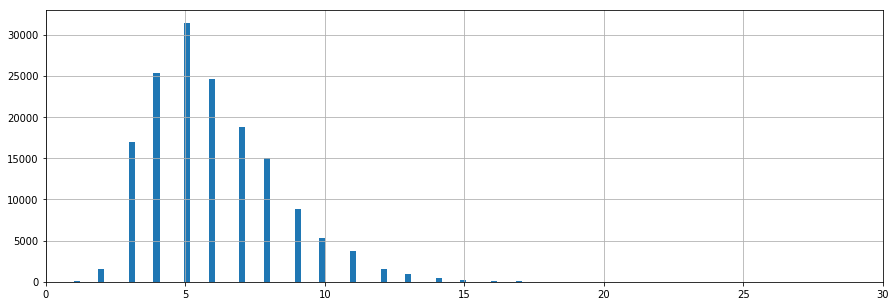

In [37]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [38]:
corpus_tokens_stem[diffs == 2][:10]

array([list(['ям']), list(['ос']), list(['об']), list(['ум']),
       list(['то']), list(['ин']), list(['то']), list(['мо']),
       list(['им']), list(['ма'])], dtype=object)

In [39]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.10839984257150415

In [40]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

16801 16801


In [41]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

16801 16801


In [42]:
texts

array(['разобрались,', 'купить', 'дешёвую', ..., 'мчался', 'баллон',
       'пассажирка'], dtype='<U31')

In [43]:
diffs = np.asarray([len(tokens[0]) for tokens in corpus_tokens_stem])
print(len(diffs))

16801


In [44]:
diffs

array([7, 3, 5, ..., 4, 6, 9])

(0, 10)

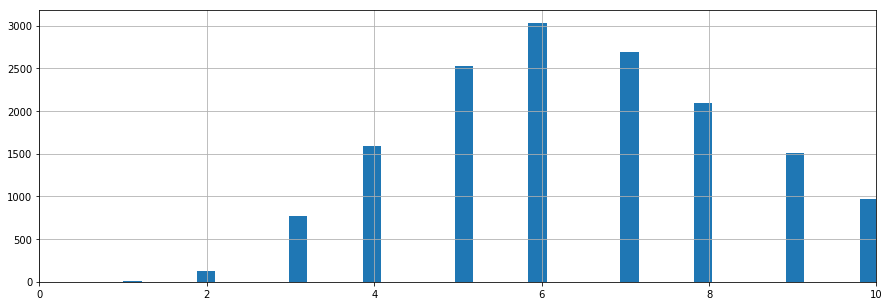

In [45]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [46]:
corpus_tokens_stem[diffs == 7]

array([list(['разобра']), list(['коридор']), list(['страхов']), ...,
       list(['браслет']), list(['миловск']), list(['лесовоз'])],
      dtype=object)

In [47]:
corp4learning = corpus_tokens_stem[diffs > 2]
texts4learning = texts[diffs > 2]

In [48]:
corp4learning

array([list(['разобра']), list(['куп']), list(['дешев']), ...,
       list(['мчал']), list(['баллон']), list(['пассажирк'])],
      dtype=object)

In [49]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [50]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

16629


In [14]:
import os
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.neighbors import NearestNeighbors
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

%matplotlib inline

In [15]:
data_train = []
for j in df["text"]:
    data_train.append(j)

In [20]:
data_train[0]

'Мы разобрались, можно ли купить дешёвую страховку по новым тарифам Мы разобрались, можно ли купить дешёвую страховку по новым тарифам С начала года коридор тарифов ОСАГО расширили на 20% и вверх, и вниз. Это дало страховым компаниям выбор: оставить цены, повысить или снизить. Мы проанализировали стоимость полисов в регионах России, и оказалось, что найти страховку подешевле действительно можно — тарифы страховых компаний отличаются сильнее, чем в прошлом году. Гибкие тарифы ОСАГО должны были «наказать» аварийных водителей, но на деле всё оказалось не так Под флагом заботы о водителях Стоимость полиса ОСАГО зависит от базового тарифа, который умножается на восемь коэффициентов: территориальный, аварийности (КБМ), опыта и стажа, мощности и так далее. В прошлом году вилка базового тарифа составляла 3432–4118, сейчас её раздвинули до 2746–4942 рублей — вилка эта определена законом об ОСАГО. То есть в теории можно найти полис, который ощутимо дешевле прошлогоднего. Реформу, поведённую Банк

In [21]:
vectorizer = TfidfVectorizer(stop_words=None, strip_accents='unicode')
tfidf_train = vectorizer.fit_transform(data_train)

print(tfidf_train.shape)

(360, 45931)


<360x45931 sparse matrix of type '<class 'numpy.float64'>'
	with 156417 stored elements in Compressed Sparse Row format>

In [16]:
predictor = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine').fit(tfidf_train)

In [62]:
near = NearestNeighbors(n_neighbors=1, algorithm='brute', metric="euclidean").fit(tfidf_train)

In [107]:
near_1 = NearestNeighbors(n_neighbors=1, algorithm='brute', metric="cityblock").fit(tfidf_train)

In [27]:
request = "Где в России с туристов начнут собирать деньги"

In [28]:
tfidf_test = vectorizer.transform([vectorizer.decode(request)])

print(tfidf_test.shape)

(1, 45931)


In [29]:
vectorizer.vocabulary_

{'мы': 20037,
 'разобрались': 33676,
 'можно': 19562,
 'ли': 17695,
 'купить': 17154,
 'дешевую': 9599,
 'страховку': 39353,
 'по': 27145,
 'новым': 22284,
 'тарифам': 40107,
 'начала': 21094,
 'года': 8062,
 'коридор': 16274,
 'тарифов': 40113,
 'осаго': 24267,
 'расширили': 34299,
 'на': 20101,
 '20': 294,
 'вверх': 4761,
 'вниз': 5716,
 'это': 45645,
 'дало': 8934,
 'страховым': 39366,
 'компаниям': 15859,
 'выбор': 6804,
 'оставить': 24492,
 'цены': 44153,
 'повысить': 27364,
 'или': 13754,
 'снизить': 37438,
 'проанализировали': 31619,
 'стоимость': 39202,
 'полисов': 28632,
 'регионах': 34434,
 'россии': 35096,
 'оказалось': 23618,
 'что': 44695,
 'наити': 20425,
 'подешевле': 27674,
 'деиствительно': 9276,
 'тарифы': 40115,
 'страховых': 39368,
 'компании': 15856,
 'отличаются': 24972,
 'сильнее': 36489,
 'чем': 44395,
 'прошлом': 32754,
 'году': 8081,
 'гибкие': 7854,
 'должны': 10166,
 'были': 4498,
 'наказать': 20435,
 'аварииных': 1816,
 'водителеи': 5777,
 'но': 22189,
 'де

In [30]:
print(tfidf_test)

  (0, 41344)	0.477719078038
  (0, 37557)	0.564804426715
  (0, 35096)	0.224974509771
  (0, 21163)	0.503216404834
  (0, 9413)	0.340148048695
  (0, 7748)	0.182316940709


In [31]:
for i in tfidf_test.indices:
    print(str(i) + " " + str(vectorizer.get_feature_names()[i]))

41344 туристов
37557 собирать
35096 россии
21163 начнут
9413 деньги
7748 где


In [96]:
distances, inds_pred = predictor.kneighbors(tfidf_test, n_neighbors=13)

In [90]:
distances_1, inds_pred_1 = near.kneighbors(tfidf_test, n_neighbors=13)

In [108]:
distances_2, inds_pred_2 = near_1.kneighbors(tfidf_test, n_neighbors=13)

In [109]:
distances = np.squeeze(distances)
inds_pred = np.squeeze(inds_pred)
distances_1 = np.squeeze(distances_2)
inds_pred_1 = np.squeeze(inds_pred_2)

(0, 1)

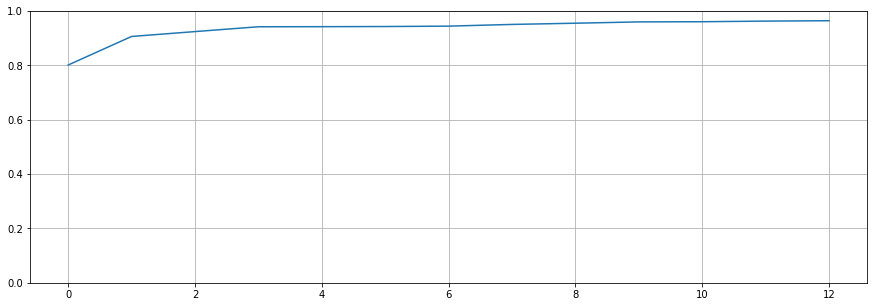

In [110]:
plt.figure(figsize=(15, 5))

plt.plot(distances)
plt.grid(True)
plt.ylim(0, 1)

(6, 12)

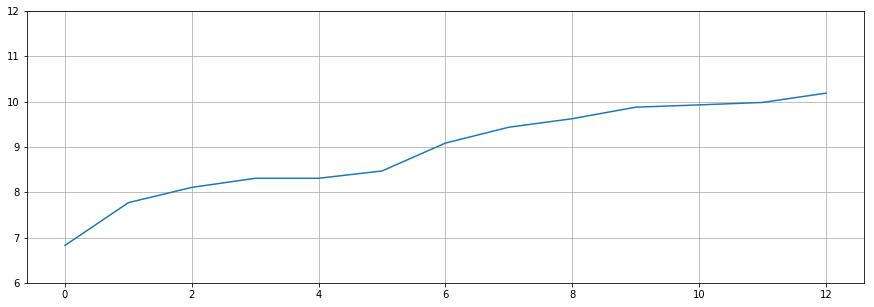

In [122]:
plt.figure(figsize=(15, 5))

plt.plot(distances_1)
plt.grid(True)
plt.ylim(6, 12)

In [112]:
inds_pred

array([157, 148, 146, 337, 194, 133, 153, 188, 158,   6, 332, 193, 136], dtype=int64)

In [113]:
inds_pred_1

array([ 62,  88, 351,  95, 211, 227, 352, 341,  85,  97,  60,  40, 190], dtype=int64)

In [117]:
for i, item in enumerate(inds_pred, start=1):
    print('--------------------------- Top-{} ---------------------------'.format(i))
    print(data_train[item])
    print('---------------------------- end -----------------------------')
    print()

--------------------------- Top-1 ---------------------------
Где в России с туристов начнут собирать деньги на благоустройство и зачем всем приезжим в городах, принимающих мундиаль, надо будет идти в полицию — читайте в нашем материале о новых законах, которые вступят в силу в мае 2018 года. Минимальная зарплата в России вырастет до 11 163 рублей Минимальную зарплату подтянут к прожиточному минимуму С 1 мая 2018 года федеральный МРОТ вырастает на 17% — до 11 163 рублей в месяц. Сейчас МРОТ составляет 9489 рублей. Его приравняли к величине прожиточного минимума трудоспособного населения в России. Так что теперь ежемесячная зарплата россиянина не может быть ниже 11 163 рублей. Но учтите, что это сумма до вычета НДФЛ, то есть на руки будут выплачивать на 13% меньше. МРОТ используют для начисления минимального размера пособий по временной нетрудоспособности или по беременности и родам. В большинстве регионов страны МРОТ и так выше, чем федеральный минимум, поэтому на их жизни нововведение

In [118]:
for i, item in enumerate(inds_pred_1, start=1):
    print('--------------------------- Top-{} ---------------------------'.format(i))
    print(data_train[item])
    print('---------------------------- end -----------------------------')
    print()

--------------------------- Top-1 ---------------------------
Их планируется обустроить в этом году Их планируется обустроить в этом году В Нижнем Новгороде в этом году власти планируют сделать 56 платных парковок. Это и небольшие территории возле нескольких домов, и целые улицы. NN.RU составил карту будущих стоянок. Скоро почти все парковки в центре Нижнего станут платными Платные парковки в основном появятся в центре города, также пара стоянок станет платной в Канавинском районе. Как сообщили NN.RU в администрации Нижнего Новгорода, обустройство платных парковок планируется по адресам: Рождественская ул. от д. №17 до д. №49; Маркина пл.; Нагорный пер.; Алексеевская ул. у д.№2; Алексеевская ул. от пл. Минина до ул. Пискунова; Алексеевская ул. от д. №7 по д. №9; Алексеевская ул. от д. №24 до д. №26; Алексеевская ул. от ул. Октябрьская до ул. Грузинская; А. Блохиной ул. от ул. Варварская до ул. Ковалихинская; Белинского ул. от ТЦ Шоколад до ул. Ванеева; Б. Печерская ул. от ул. Пискунова

# Build Models

In [86]:
dataframe_auto = dataframe[dataframe.genre == "AUTO"][:60]
dataframe_winter = dataframe[dataframe.genre == "WINTER"][:60]
dataframe_world = dataframe[dataframe.genre == "WORLD"][:60]
dataframe_town = dataframe[dataframe.genre == "TOWN"][:60]
dataframe_accidents = dataframe[dataframe.genre == "ACCIDENTS"][:60]
# Изменить 60 на 61:72

In [87]:
dataframe_auto_2 = dataframe[dataframe.genre == "AUTO"][61:72]
dataframe_winter_2 = dataframe[dataframe.genre == "WINTER"][61:72]
dataframe_world_2 = dataframe[dataframe.genre == "WORLD"][61:72]
dataframe_town_2 = dataframe[dataframe.genre == "TOWN"][61:72]
dataframe_accidents_2 = dataframe[dataframe.genre == "ACCIDENTS"][61:72]

In [88]:
frames = [dataframe_auto, dataframe_winter, dataframe_world, dataframe_town, dataframe_accidents]
df_train_m = pd.concat(frames)

In [89]:
frames = [dataframe_auto_2, dataframe_winter_2, dataframe_world_2, dataframe_town_2, dataframe_accidents_2]
df_test_m = pd.concat(frames)

In [90]:
len(df_train_m)

300

In [91]:
len(df_test_m)

55

In [92]:
df_test_m[:5]

,genre,text
65,AUTO,"Новая подборка про людей, которые паркуются ка..."
66,AUTO,Их планируется обустроить в этом году Их плани...
67,AUTO,Короли парковки: «Крузак головного мозга» Нова...
68,AUTO,Вот и прошел 2017 год. Вроде бы всего 12 месяц...
69,AUTO,Автохамы в гостях у NN.RU Автохамы в гостях у ...


In [105]:
data_F = []
for item in df["text"]:
    data_F.append(item)

In [111]:
len(y_train)

300

In [173]:
data_F[:2]

['Мы разобрались, можно ли купить дешёвую страховку по новым тарифам Мы разобрались, можно ли купить дешёвую страховку по новым тарифам С начала года коридор тарифов ОСАГО расширили на 20% и вверх, и вниз. Это дало страховым компаниям выбор: оставить цены, повысить или снизить. Мы проанализировали стоимость полисов в регионах России, и оказалось, что найти страховку подешевле действительно можно — тарифы страховых компаний отличаются сильнее, чем в прошлом году. Гибкие тарифы ОСАГО должны были «наказать» аварийных водителей, но на деле всё оказалось не так Под флагом заботы о водителях Стоимость полиса ОСАГО зависит от базового тарифа, который умножается на восемь коэффициентов: территориальный, аварийности (КБМ), опыта и стажа, мощности и так далее. В прошлом году вилка базового тарифа составляла 3432–4118, сейчас её раздвинули до 2746–4942 рублей — вилка эта определена законом об ОСАГО. То есть в теории можно найти полис, который ощутимо дешевле прошлогоднего. Реформу, поведённую Бан

In [108]:
data_full_ = vectorizer.fit_transform(data_F)

In [113]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_full_, df["genre"])

In [164]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=30, window=2, min_count=1, workers=4)

In [168]:
model.docvecs[0]

array([ 0.75435251, -0.84884143,  1.02085602, -1.2646836 ,  0.6404984 ,
       -0.98779517, -1.98133409, -2.44583535,  1.66087008, -0.6543957 ,
       -0.90666759, -1.37917614,  1.07633352,  0.44287977,  0.02242515,
        1.08529127,  1.68683302,  0.25867757,  0.15885299,  0.47093877,
        0.36399394, -0.33786944, -1.35673201,  0.44339177, -2.58695459,
        0.85597819,  0.30063882,  0.25870949, -0.67346972,  0.08685511], dtype=float32)

In [114]:
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(270, 45931) (90, 45931)
270 90


In [118]:
import os
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import itertools
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

%matplotlib inline

In [202]:
len(y_test[y_test == "WINTER"])

20

In [199]:
index_of_texts = y_test[(y_test == "WINTER") & (y_pred_lr == "WORLD")]
llll = list(index_of_texts.index)

In [201]:
for i in llll:
    print(data_F[i])
    print("-------------------------------------------------")

В воскресенье, 22 февраля, нижегородцы смогут весело и вкусно попрощаться с зимой. Опубликована программа празднования Масленицы в Нижнем Новгороде. С 15 по 22 февраля на Нижегородской ярмарке проходит выставка-ярмарка «Широкая масленица». Участники смогут купить изделия ручной работы, поучаствовать в мастер-классах, угоститься блинами, послушать музыку и посмотреть выступления любительских театров. В грядущие выходные для гостей и жителей поволжской столицы организуют серию праздничных мероприятий, посвященных яркому зимнему празднику. В разных районах города пройдут театральные представления, концерты, традиционные народные состязания. Нижегородцы смогут поесть блинов и выпить чая.В ТЕМУ:с 12 до 17 часов будут проводиться конкурсы и игры. Нижегородцы смогут побывать на ярмарке народных ремесел и мастер-классах, поучаствовать в ежегодном чемпионате по поеданию блинов, конкурсе на самую красивую масленицу. Весь день по улице Рождественской будет курсировать экскурсионный трамвай.с 14 д

In [189]:
index_of_texts = y_test[y_test == "WINTER" & y_pred_lr == "WORLD"]

for ind in list(y_test.index):
    if y_test[ind] == "WINTER" and y_pred_lr[ind] == "WORLD":
        index_of_text.append(ind)
for i in index_of_texts:
    print(data_F[i])

IndexError: index 129 is out of bounds for axis 0 with size 90

In [178]:
data_F[:2]

['Мы разобрались, можно ли купить дешёвую страховку по новым тарифам Мы разобрались, можно ли купить дешёвую страховку по новым тарифам С начала года коридор тарифов ОСАГО расширили на 20% и вверх, и вниз. Это дало страховым компаниям выбор: оставить цены, повысить или снизить. Мы проанализировали стоимость полисов в регионах России, и оказалось, что найти страховку подешевле действительно можно — тарифы страховых компаний отличаются сильнее, чем в прошлом году. Гибкие тарифы ОСАГО должны были «наказать» аварийных водителей, но на деле всё оказалось не так Под флагом заботы о водителях Стоимость полиса ОСАГО зависит от базового тарифа, который умножается на восемь коэффициентов: территориальный, аварийности (КБМ), опыта и стажа, мощности и так далее. В прошлом году вилка базового тарифа составляла 3432–4118, сейчас её раздвинули до 2746–4942 рублей — вилка эта определена законом об ОСАГО. То есть в теории можно найти полис, который ощутимо дешевле прошлогоднего. Реформу, поведённую Бан

In [120]:
predictor_lr = LogisticRegression().fit(X_train, y_train)

In [121]:
predictor_svm = LinearSVC().fit(X_train, y_train)

In [122]:
predictor_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [123]:
predictor_gbt = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

In [125]:
y_pred_lr = predictor_lr.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_test == y_pred_lr), 2)))

LR accuracy: 0.83%


In [126]:
y_pred_svm = predictor_svm.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_test == y_pred_svm), 2)))

LR accuracy: 0.8%


In [127]:
y_pred_rf = predictor_rf.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_test == y_pred_rf), 2)))

RF accuracy: 0.68%


In [128]:
y_pred_gbt = predictor_gbt.predict(X_test)
print('GBT accuracy: {}%'.format(round(np.mean(y_test == y_pred_gbt), 2)))

GBT accuracy: 0.63%


In [129]:
def plot_confusion_matrix(cm, title='Contingency matrix'):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[0])
    classes = [x.split('.')[-1] for x in initial_categories]
    plt.xticks(tick_marks, classes, rotation=45, size=14)
    plt.yticks(tick_marks, classes, size=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

In [132]:
initial_categories = ["AUTO", 'WINTER', 'WORLD', 'TOWN', 'ACCIDENTS']

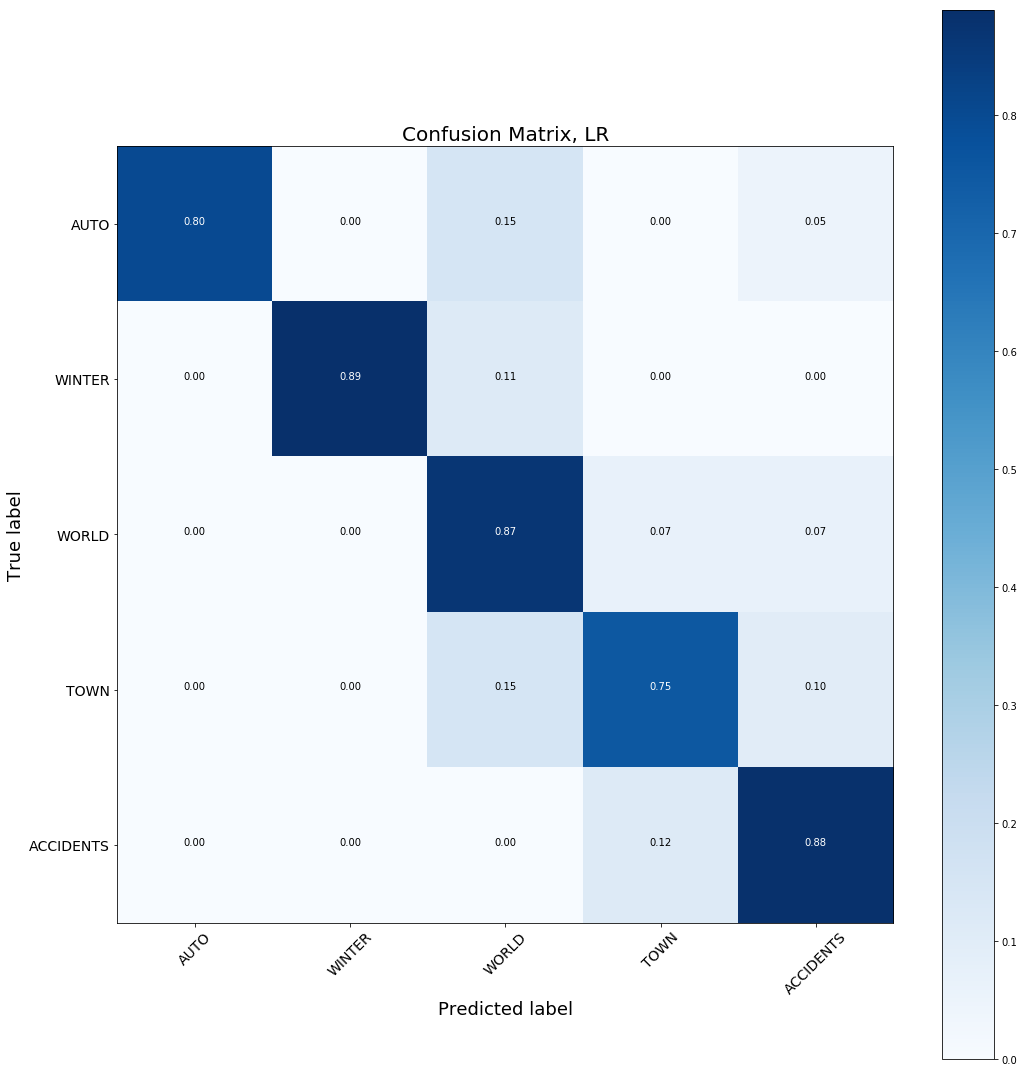

In [133]:
cmt_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix(cmt_lr, title='Confusion Matrix, LR')

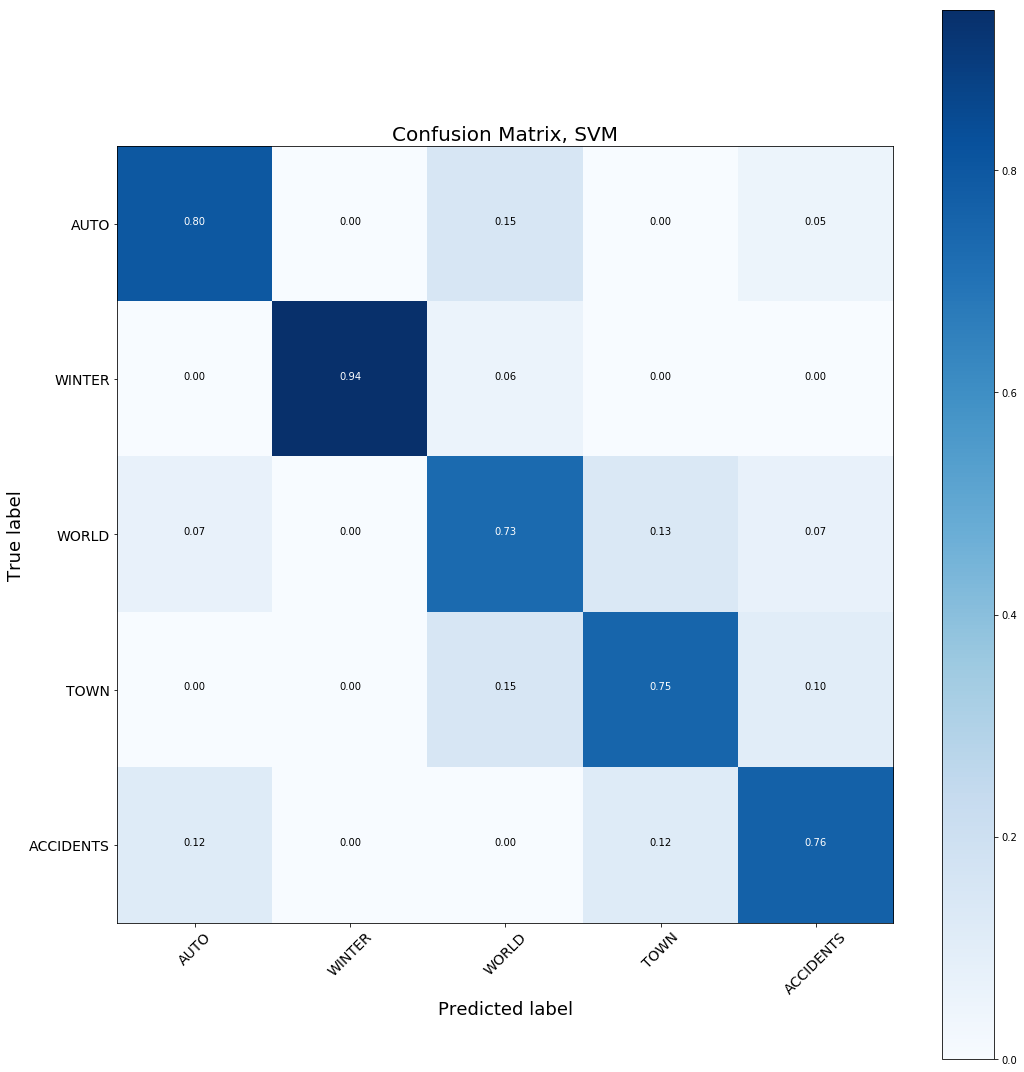

In [134]:
cmt_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cmt_svm, title='Confusion Matrix, SVM')

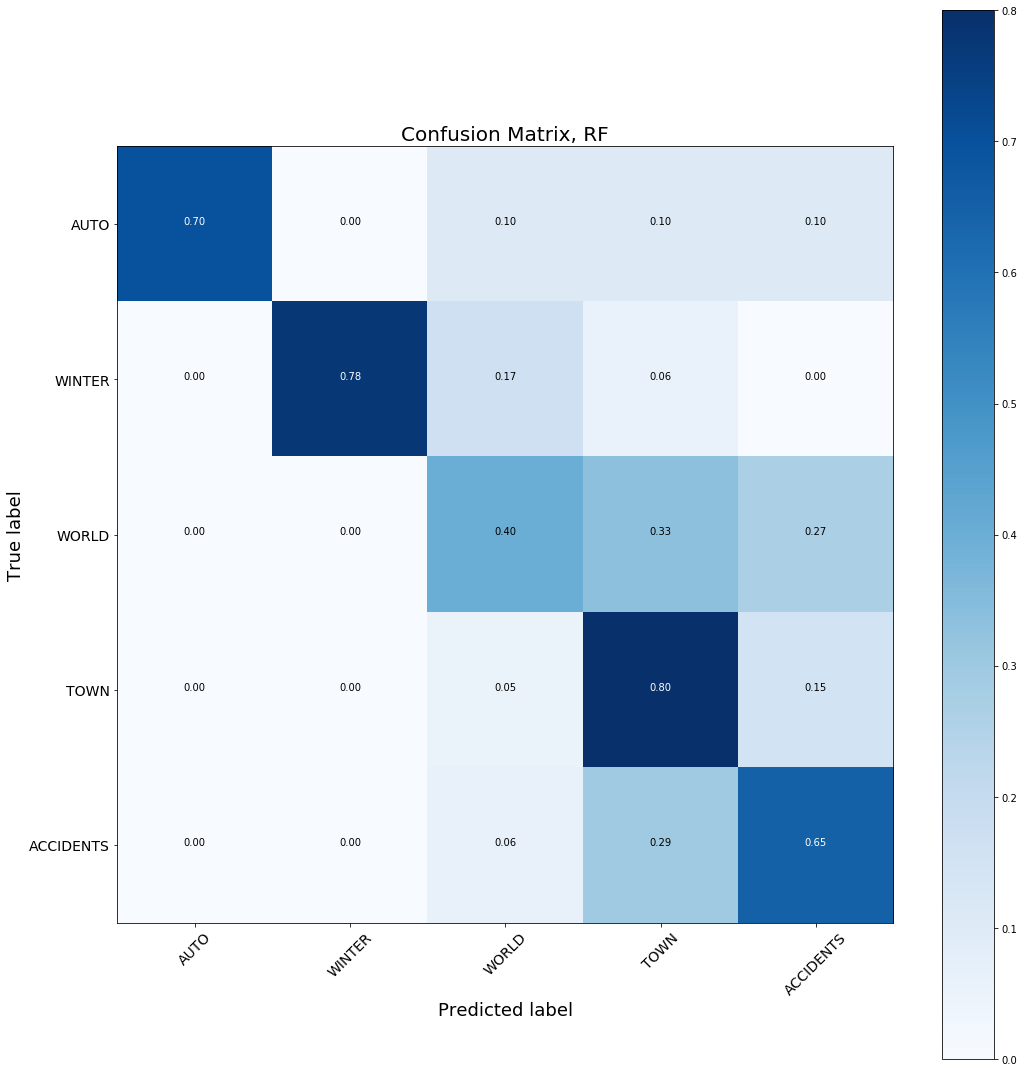

In [135]:
cmt_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cmt_rf, title='Confusion Matrix, RF')

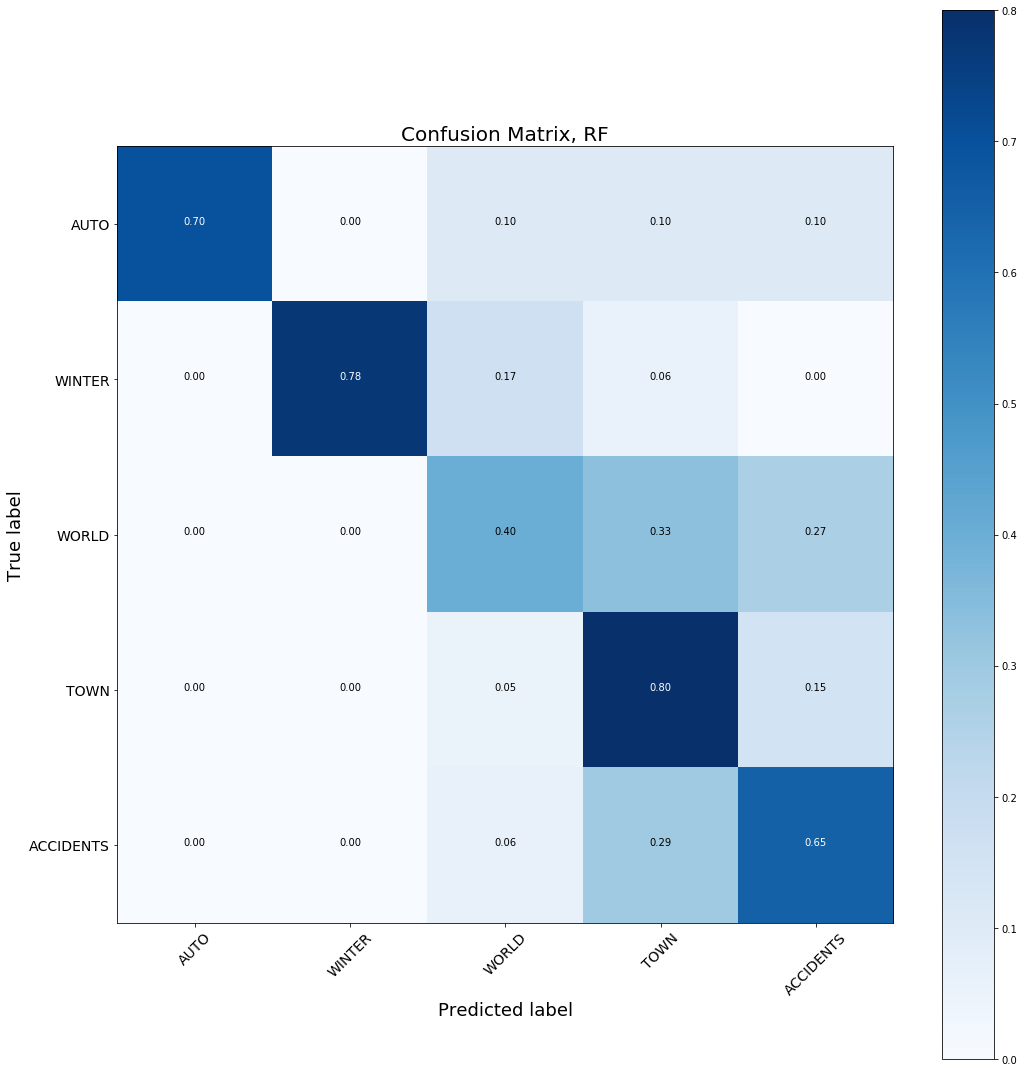

In [136]:
cmt_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cmt_rf, title='Confusion Matrix, RF')

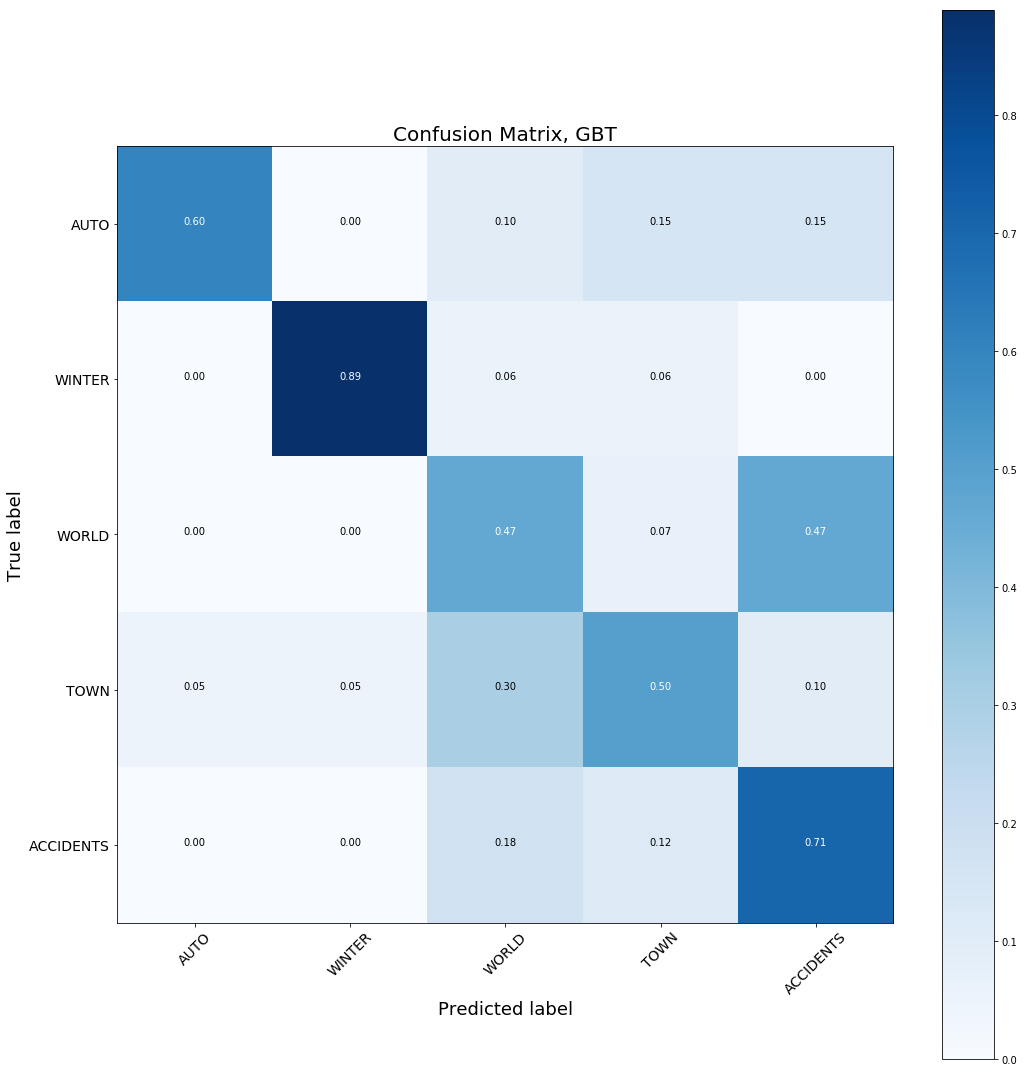

In [137]:
cmt_gbt = confusion_matrix(y_test, y_pred_gbt)
plot_confusion_matrix(cmt_gbt, title='Confusion Matrix, GBT')

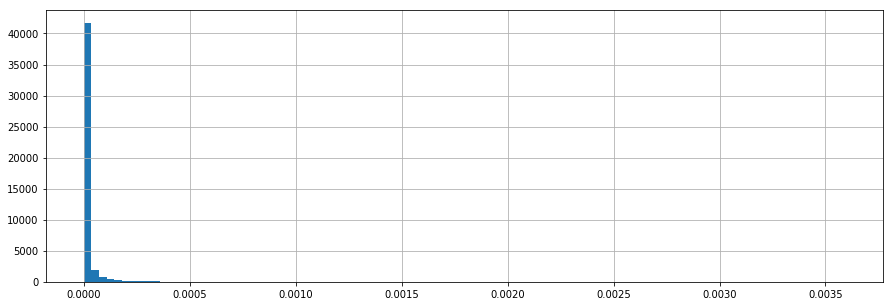

In [138]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)

(0, 0.001)

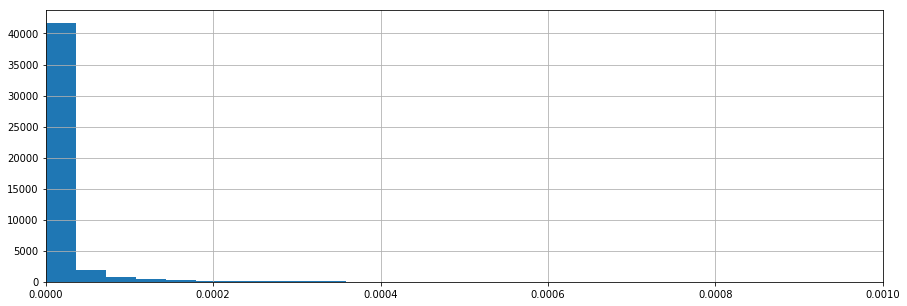

In [139]:
plt.figure(figsize=(15, 5))

plt.hist(predictor_rf.feature_importances_, bins=100)
plt.grid(True)
plt.xlim(0, 0.001)

In [140]:
feature_selector = SelectFromModel(RandomForestClassifier(n_estimators=10)).fit(X_train, y_train)

In [142]:
X_train_transformed = feature_selector.transform(X_train)
X_test_transformed = feature_selector.transform(X_test)

print(X_train_transformed.shape, X_test_transformed.shape)

(270, 714) (90, 714)


In [143]:
predictor_lr_ = LogisticRegression().fit(X_train_transformed, y_train)

In [144]:
y_pred_lr_ = predictor_lr_.predict(X_test_transformed)
print('LR (with feature selection) accuracy: {}%'.format(round(np.mean(y_test == y_pred_lr_), 2)))

LR (with feature selection) accuracy: 0.62%


In [145]:
predictor_oneVSall = OneVsRestClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [146]:
y_pred_onevsall = predictor_oneVSall.predict(X_test)
print('One-VS-all accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsall), 2)))

One-VS-all accuracy: 0.8%


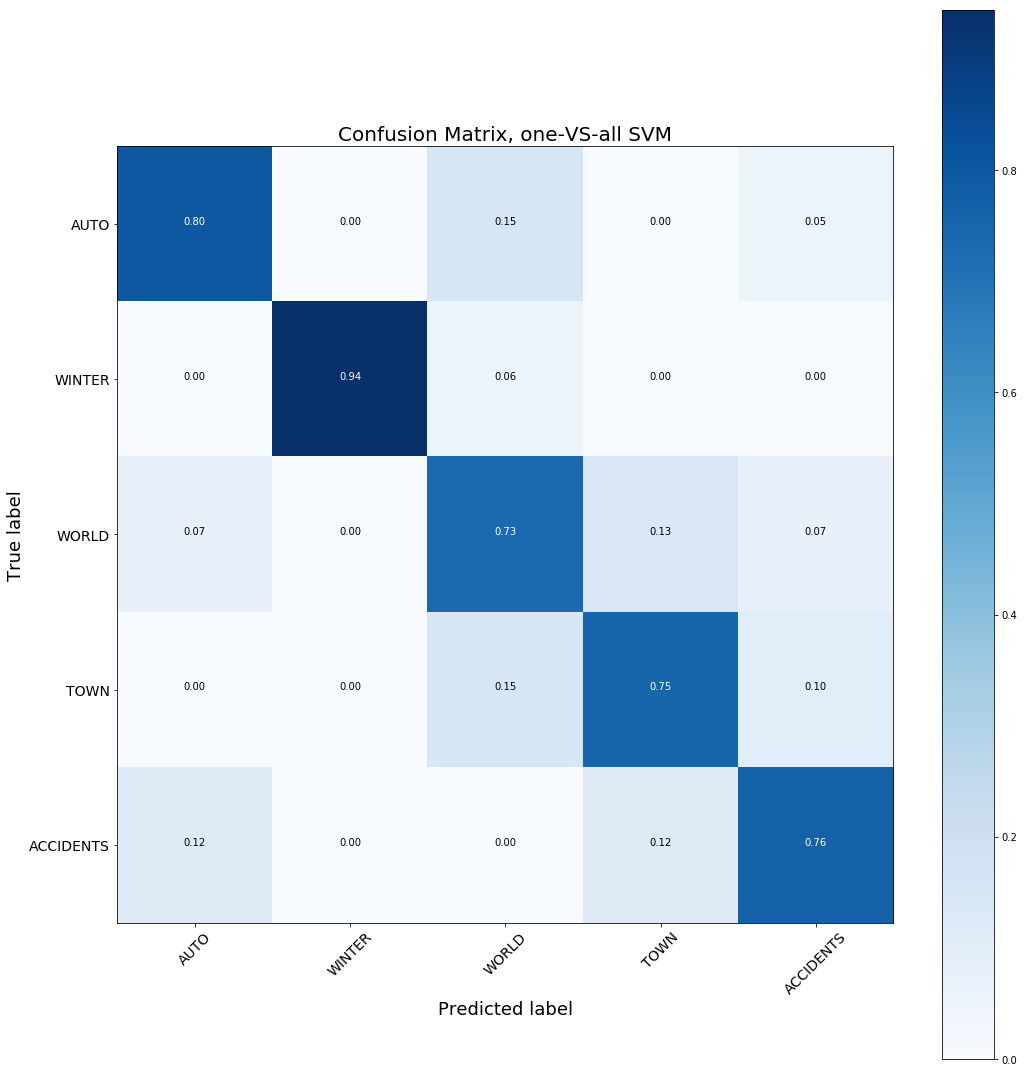

In [147]:
cmt_svm_onevsall = confusion_matrix(y_test, y_pred_onevsall)
plot_confusion_matrix(cmt_svm_onevsall, title='Confusion Matrix, one-VS-all SVM')

In [148]:
predictor_oneVSone = OneVsOneClassifier(LinearSVC(), n_jobs=8).fit(X_train, y_train)

In [150]:

y_pred_onevsone = predictor_oneVSone.predict(X_test)
print('One-VS-one accuracy: {}%'.format(round(np.mean(y_test == y_pred_onevsone), 2)))

One-VS-one accuracy: 0.8%


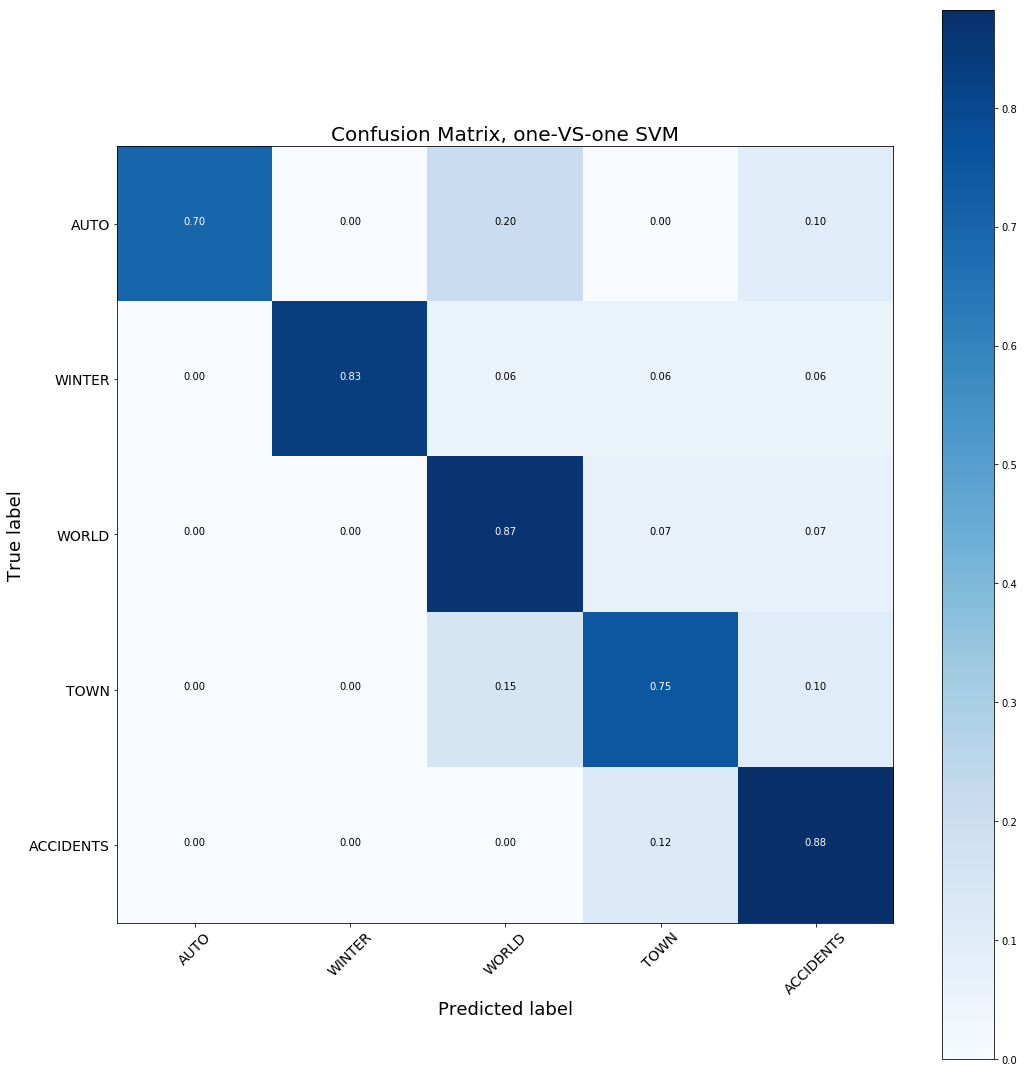

In [151]:
cmt_svm_onevsone = confusion_matrix(y_test, y_pred_onevsone)
plot_confusion_matrix(cmt_svm_onevsone, title='Confusion Matrix, one-VS-one SVM')

In [152]:
for c in np.unique(y_train):
    print('Class \'{}\' samples N: {}'.format(c, y_train[y_train == c].shape[0]))

Class 'ACCIDENTS' samples N: 52
Class 'AUTO' samples N: 54
Class 'TOWN' samples N: 57
Class 'WINTER' samples N: 52
Class 'WORLD' samples N: 55


In [218]:
np.unique(df_test_m["genre"])

array(['ACCIDENTS', 'AUTO', 'TOWN', 'WINTER', 'WORLD'], dtype=object)

In [109]:
#genre_list = ["AUTO", 'WINTER', 'WORLD', 'TOWN', 'ACCIDENTS']
genre_list = [0, 1, 2, 3, 4]
y_train = []
y_test = []
for i in range(1, X_train.shape[0] + 1):
    if i <= 60:
        y_train.append(genre_list[0])
    if 60 < i and i <= 120:
        y_train.append(genre_list[1])
    if 120 < i and i <= 180:
        y_train.append(genre_list[2])
    if 180 < i and i <= 240:
        y_train.append(genre_list[3])
    if 240 < i and i <= 300:
        y_train.append(genre_list[4])
        
"""
for i in range(1, X_test.shape[0] + 1):
    if i <= 11:
        y_test.append(genre_list[0])
    if 11 < i and i <= 22:
        y_test.append(genre_list[1])
    if 22 < i and i <= 33:
        y_test.append(genre_list[2])
    if 33 < i and i <= 44:
        y_test.append(genre_list[3])
    if 44 < i and i <= 55:
        y_test.append(genre_list[4])
"""

'\nfor i in range(1, X_test.shape[0] + 1):\n    if i <= 11:\n        y_test.append(genre_list[0])\n    if 11 < i and i <= 22:\n        y_test.append(genre_list[1])\n    if 22 < i and i <= 33:\n        y_test.append(genre_list[2])\n    if 33 < i and i <= 44:\n        y_test.append(genre_list[3])\n    if 44 < i and i <= 55:\n        y_test.append(genre_list[4])\n'

In [264]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [165]:
import os
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import itertools
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

%matplotlib inline

In [166]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
initial_categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                      'comp.sys.mac.hardware', 'comp.windows.x', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
                      'rec.sport.hockey', 'sci.electronics', 'soc.religion.christian', 'talk.politics.mideast',
                      'talk.politics.misc', 'talk.religion.misc']

In [171]:
ng_train = fetch_20newsgroups(subset='train', categories=initial_categories, remove=('headers', 'footers', 'quotes'))
print(np.unique(ng_train.target))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [170]:
len(initial_categories)

15

In [279]:
predictor_lr = LogisticRegression().fit_transform(X_train, y_train)

AttributeError: 'LogisticRegression' object has no attribute 'fit_transform'

In [278]:
predictor_svm = LinearSVC().fit(X_train, y_train)

ValueError: could not convert string to float: 'На автомобиле «для путешествий» мы отправились в путешествие и поняли, что размер не всегда выгоден На автомобиле «для путешествий» мы отправились в путешествие и поняли, что размер не всегда выгоден Что такое несвобода, отчетливее всего понимаешь в свободной Европе. Несвободу здесь ощущаешь физически, пытаясь втиснуться в щель подземной парковки настолько узкую, что инстинктивно прижимаешь локти. Зеркало автомобиля проходит в сантиметре от стены, а взгляд упирается в табличку «37 евро», которая означает то ли суточную плату, то ли штраф в случае отказа платить. Ну его. Мы пятимся назад, всё также прижимая локти и, на всякий случай, втягивая щёки. Снаружи кажется, что всё не так страшно... узко ... но изнутри ощущаешь будто вот-вот снимешь скальп со стен. Судя по отметинам, прецеденты были То, что автомобилям размером со SKODA Kodiaq в Барселоне и её окрестностях не очень рады, хорошо понимаешь, отыскав-таки сносную парковку (три евро в час), которая выглядит тесноватой даже для Daewoo Matiz. Если умудришься встать ровно, не откроешь двери, и наоборот. Так началось моё знакомство с Kodiaq российской сборки, которое, вопреки ожиданиям, прошло в полной интриг и заговоров столице Каталонии. Что справа, что слева — впритык. И эта парковка считается просторной Поэтому камера заднего вида и круговой «парктроник» не являются здесь излишеством. Тем более свирепые каталонцы даже в пробках притираются так, что парктроник издает затяжной писк и впадает в кому. Они бы, наверное, ехали до контакта, но московские номера нашего Kodiaq действуют, как чеснок на вампиров. Наша первая цель: храм Sagrada Familia начали строить в 1882 году, а закончат, предположительно, в 2026 году, через сто лет после смерти Антонио Гауди Конечно, мы не могли упустить возможность зайти внутрь Пытку теснотой оправдал вид фантастического храма Sagrada Familia, от которого мой напарник исторг речитатив, в наших краях означающий восхищение на грани религиозного восторга. То, что издалека казалось шероховатостью, при ближайшем рассмотрении предстало миниатюрными (в человеческий рост) фресками. Глядя на «Саграду», хорошо представляешь, как раскалённый маховик фантазии Антонио Гауди наслаивал поверх всё новые и новые слои — это произведение сложно назвать зданием, скорее, это выбитое в камне кипение религиозного сна. Колья башенных кранов, протыкающих храм примерно посредине, лишь подчеркивают его нечеловеческий масштаб. Большая часть дорог огорожена барьером, но встречаются и заманчивые бреши А кругом — лепота и плюс 15 по Цельсию Каталония — самый богатый регион Испании, поэтому дороги здесь лишены южного колорита и творческой щербатости. Они настолько хорошие и настолько платные, что большую часть времени на автомагистралях выковыриваешь из зубов хамон и уворачиваешься от летящих позади испанцев, которые чтят лимиты скорости чуть меньше, чем футбольный клуб «Барселона». Дороги в Испании прекрасные до такой степени, что аж зло берёт Но много платных. Например, за 350 километров от Барселоны до Валенсии попросят 41 евро — более 3000 рублей Конечно, этой расслабленности добавляет и сам Kodiaq, который по шкодовским меркам является автомобилем мягким и даже как будто чересчур. На испанских дорогах он едет, задержав дыхание, потому что для вздохов нет ни одной интересной кочки. Даже грунтовки словно утрамбовали катком Kodiaq здорово скрадывает ощущение скорости, поэтому умный круиз-контроль — совсем не лишнее изобретение Мы движемся в сторону одной любопытной винодельни, уповая большая частью на активный круиз-контроль, который выдерживает разрешенные 120 км/час и самостоятельно притормаживает перед фурами, да так хорошо, что через пару часов навык тормозить забывается напрочь. Единственным неудобством является его внимание к автомобилям на полосах для разгона и торможения, при подъезде к которым он интенсивно тормозит, хотя препятствие находится в трех метрах правее тебя. Близ Барселоны много потрясающих горных дорог, которые убивают жесткие ограничения скорости Мягкость Kodiaq хорошо заметна на кружевных серпантинах Каталонских гор. Хотя по меркам кроссоверов он весьма точен, Octavia и Superb всё же интереснее. У них лучше отклик в начальной фазе и больше злости в ответ на ускорение посреди поворота: если тот же Superb грызёт асфальт и стремится внутрь, Kodiaq норовит засвистеть шинами и выскользнуть наружу. Уйти вразнос ему не дает система стабилизации, но сам характер автомобиля не предполагает гонок. Kodiaq может ехать быстро и резко, но инициативы не проявляет и мало-помалу успокаивает и водителя Не предполагают гонок и каталонские дороги, которые, признаться, вынимают душу абсурдными ограничениями скорости. Ну хорошо — абсурдными с точки зрения нас, залётных. Но всё-таки от необходимости каждые 200 метров сбрасывать скорость до 40 в душе просыпается какое-то эпилептическое чувство. К тому же дотошная система навигации Kodiaq отражает лимиты скорости на экране, но принимает знак «Рекомендованная скорость» за жёсткое ограничение, что неплохо с точки зрения безопасности, но действует на нервы. Скоростные лимиты, впрочем, оправданы: дороги в самом деле провоцируют Невозмутимые велосипедисты так и не уступили Но ограничения скорости — это хотя бы в наших интересах. Чтобы вы поняли кабальность испанских законов, штрафы в размере 5000–8000 рублей ждут здесь за вождение в шлёпанцах, езду с локтем на «подоконнике», поедание мороженого или распитие воды за рулём. Сделано это, дабы под благим предлогом выдоить до нитки туристов, что наводняют Барселону с весны по раннюю осень. Представляете, какое зловоние поднялось бы в России, если бы у нас запретили пить за рулём воду? Не все ещё переварили запрет алкоголя, а тут — вода. Наверняка её употребление гарантировано какой-нибудь статьей Конституции. Определить Kodiaq можно в двух словах с помощью эпитетов «покладистость» и «практичность». Первое ты понимаешь за рулём, и хорошо это или плохо, зависит от настроя: если в крови ещё играют гормоны радости, нужно ждать версию Kodiaq RS. Что касается практичности, в какой-то момент начинаешь жалеть, что с тобой нет твоих спиногрызов с их самокатами, великами и чемоданом самого необходимого (на два-то дня...), чтобы щегольнуть багажником на 600 литров. Двое мужчин в Kodiaq ощущают себя этакими ёжиками в тумане, которые сами не понимают, что им делать с этим пространством вокруг. Вечерами атмосфера становится призрачной Если, выбирая Kodiaq, вы не можете определиться с двигателем, то вот небольшой гид. Младший 125-сильный мотор является дефорсированной версией 150-сильного 1.4 TSI, и оба обеспечивают Kodiaq убедительную динамику — разгон до 100 км/час в районе 10 секунд. Они являются вполне здравым выбором для автомобиля, который используется преимущественно в городе. Оба мотора относятся к семейству EA211, которое отличается от первой генерации мотором TSI весьма существенно. Для межгорода предпочтительнее 2-литровый 180-сильный турбомотор, который снимает с времени разгона пару секунд и имеет более «мясистую» середину рабочего диапазона, позволяя обгонять засыпающих испанских фермеров одним щелчком кнута. Наиболее сбалансированный для России двигатель — 2.0 TSI (180 л. с.) Что до дизеля, он оправдан в основном для настоящих путешественников: по нашим оценкам, окупаемость наступает через 150 тысяч километров. При этом динамика дизеля всё же уступает бензиновому варианту, поэтому для России золотой серединой является именно последний. Кстати, Kodiaq с двухлитровым мотором оснащается относительно новым семиступенчатым «роботом» DQ500, который за счёт «мокрого» сцепления мягкостью старта напоминает классический «автомат», а в остальное время — типичную коробку DSG с её бесшовным характером переключения. В едва заметной лености, с которой Kodiaq трогается с места, тоже есть что-то типично «кодиаковское»: все острые углы SKODA оставила для его дизайна, но не характера. Жёлтая лента на доме — символ независимости Что касается свободы, то у Каталонии свои идеалы. Она кутается в национальный флаг и грезит независимостью от Испании. Знаки сопротивления в виде жёлтой ленточки видны по всей округе — даже на асфальте автобанов. Скалы ведут неравный бой с зеленью: такой пейзаж типичен для Средиземноморья Очень мрачный город где-то по пути в винодельню Часовня и кладбище: здесь очень тихо и уединенно, поэтому хочется просто посидеть и забыть о графике Многие городки выглядят вот так — безлико. В них мало машин, а под вечер мало и людей, так что атмосфера несколько гнетущая Такие здания почему-то напоминают мне сказку о Чиполлино, хотя он родом не из этих краёв Встречаются затерянные в горах особняки, должно быть, жутко дорогие. Одна дорога к ним стоит не меньше самого дома А есть и настоящие замки, но это уже вотчина туристов Но вообще найти фактурное строение непросто, поэтому мы снимали Kodiaq у каждого сарая Интригующая низина: очень хотелось спуститься, но совершенно непонятно, как Лобстеры. Их сожрут на ужин обитатели горных особняков Старины здесь не стесняются, а выставляют напоказ. Ну классно же Внешне Каталонию можно принять за типичную южную страну с густой растительностью и проступающими сквозь неё скалистыми мозолями. Время от времени глаз радует какой-нибудь намоленный особняк, кладбище или ферма, но в основном архитектура каталонской глубинки лишена пафоса и несколько прямолинейна. Зажиточность региона выдаёт обилие добротных каменных домов, один из которых, самый зажиточный, и был нашей целью. Винодельня Can Rafols, куда мы приехали, описав длинную петлю по Каталонским горам Здесь находится винодельня Can Rafols. Поражают даже не завод и погреба внутри огромной скалы, которую неутомимо прогрызали целых четыре года. Больше трогает увлечённость, с которой сотрудники винодельни рассказывают о своих винах, о том, как они тормошат и нянчат бутылки, как мнут в руках пробки, как убирают осадок из кавы так, чтобы не допустить её перемерзания. Будучи за рулём, я предвидел всевозможные муки от запрета попробовать вино прямо в его колыбели, но из винодельни вышел опьяненный одними рассказами. А вождение в таком виде в Испании не возбраняется. Места располагают к виноделию и винопитию Возраст винодельни особенно заметен на заднем дворе Всё такое старинное... ...но даже осенью жизнеутверждающее Натюрморт с местными деликатесами Винный погреб, выдолбленный в огромной скале О продукте здесь рассказывают, точно о своих детях. И держат также бережно: зреющая кава (игристое вино) может рвануть, и беспокоить её понапрасну почему-то там нельзя К Барселоне мы ехали уже в темноте, когда каталонские магистрали обрели фантастические виды, будто смотришь на лавину падающих красных фонарей. Kodiaq не провоцирует биться за первенство в этом стаде, поэтому мы тошним на разрешенных 120 км/час ближе к правому ряду, изредка обгоняя совсем уж медленные фуры. Пробка где-то на подступах к Барселоне: дождь, тьма, узкие полосы. Хочу в Россию С каждой новой моделью казалось, что SKODA ищет рецепт идеального семейного автомобиля, но и Rapid, и Octavia, и даже крупный Superb порой слишком потакали человеку за рулём, чтобы выпускать их на горный серпантин. Пассажиров всегда чуть-чуть укачивало. Kodiaq справился с этой задачей: он не укачивает, а, скорее, расслабляет всех в салоне и водителя в том числе. Большую часть дороги на нём едешь, держа руль одной рукой, а вторую уместив на широкий подлокотник — это в Испании вроде бы разрешено. На тесте были исключительно машины российской сборки на зимней нешипованной резине, что привносило свой колорит: скользили они довольно-таки рано К сожалению, осенняя волна подорожания затронула и Kodiaq. Впрочем, есть и хорошие новости: в этом году начались продажи автомобилей российской сборки — и в Испании, кстати, были именно такие. Поэтому относительно импортируемого самого себя Kodiaq подешевел чуть ли не на 800 тысяч и стоит теперь от 1,389 миллиона рублей. Большая часть комплектаций теперь укладывается в 2 миллиона рублей, от которых в прошлом году прайс только начинался. Локализация позволила существенно снизить цену, но осенью началось подорожание, которое, скорее всего, продолжится с Нового года Паркуя Kodiaq, я всё же мысленно скучаю по Octavia и особенно — по Octavia RS. Может быть, она идеологически неправильна и, по большому счёту, не нужна. Зато «эрска» показывает, что семейные люди тоже хотят человеческих радостей на грани фола. И чуть-чуть за гранью.'

In [223]:
predictor_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

In [224]:
predictor_gbt = GradientBoostingClassifier(n_estimators=100).fit(X_train, y_train)

In [237]:
y_pred_lr = predictor_lr.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_train == y_pred_lr), 2)))

LR accuracy: 0.88%


In [238]:
y_pred_svm = predictor_svm.predict(X_test)
print('LR accuracy: {}%'.format(round(np.mean(y_train == y_pred_svm), 2)))

LR accuracy: 0.96%


In [239]:
y_pred_rf = predictor_rf.predict(X_test)
print('RF accuracy: {}%'.format(round(np.mean(y_train == y_pred_rf), 2)))

RF accuracy: 0.99%


In [240]:
y_pred_gbt = predictor_gbt.predict(X_test)
print('GBT accuracy: {}%'.format(round(np.mean(y_train == y_pred_gbt), 2)))

GBT accuracy: 0.99%


In [270]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train_m["text"], y_train)

In [272]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(225,) (75,)
(225, 1) (75, 1)


In [268]:
y_train = y_train.reshape((300, 1))

In [269]:
y_train.shape

(300, 1)

In [276]:
X_train = X_train.values.reshape(225, 1)
X_test = X_test.values.reshape(75, 1)

In [297]:
a = [item for j in X_train for item in j]
b =[item for j in X_test for item in j]

In [294]:
X_train[2]

array(['Девочка уехала кататься на велосипеде вечером 1 августа и не вернулась Девочка уехала кататься на велосипеде вечером 1 августа и не вернулась Маша Ложкарева пропала 1 августа вечером из садового товарищества около деревни Горный Борок Нижегородской области. Около 17.00 девочка поехала кататься на велосипеде и больше о ней не было вестей. Приметы пропавшей: худощавое телосложение, рост 164 см, русые волосы, темные глаза, носит очки. Была одета в белую футболку с рисунком, голубые джинсовые шорты, бело-синие сандалии. При себе имела мобильный телефон. Как сообщили NN.ru в поисково-спасательной группе «Рысь», ранее девочка из дома не пропадала Уже несколько часов на месте работают сотрудники правоохранительных органов и нижегородские поисковики из ПСГ «Рысь», ПСО «Волонтер» и «Лиза Алерт». Корреспондент NN.ru рассказывает о происходящем с места событий. Всех, кто обладает информацией о местонахождении девочки, просят сообщить любые данные по телефонам: 8 (831) 28-38-200 или 102. 1

# Topic Modeling

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.datasets import fetch_20newsgroups
import stop_words
import gensim
import nltk
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [24]:
EXCLUDE_SYMBOLS_STR = ''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є',
                               '‹', '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—',
                               '‘', '\x7f', '\xad', '¤', '\xa0'])

In [25]:
regex_puncts = re.compile('[%s]' % re.escape(string.punctuation))
regex_symbs = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_digits = re.compile('[%s]' % re.escape(string.digits))
regex_spaces = re.compile('[%s]' % string.printable + string.whitespace)
regex_emoji = re.compile("["
                         "\U0001F600-\U0001F64F"  # emoticons
                         "\U0001F300-\U0001F5FF"  # symbols & pictographs
                         "\U0001F680-\U0001F6FF"  # transport & map symbols
                         "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                         "]+")
morph = pymorphy2.MorphAnalyzer()

In [26]:
N_TOPICS = 4

In [27]:
texts_prep = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', ' ', txt) for txt in data_train]

In [28]:
texts_prep = [regex_emoji.sub(' ', txt) for txt in texts_prep]

In [29]:
texts_prep = [regex_puncts.sub(' ', txt) for txt in texts_prep]

In [30]:
texts_prep = [regex_symbs.sub('', txt) for txt in texts_prep]

In [31]:
texts_prep = [regex_digits.sub(' ', txt) for txt in texts_prep]

In [32]:
texts_prep = [regex_spaces.sub(' ', txt) for txt in texts_prep]

In [33]:
texts_prep = [txt.strip().replace('\t', ' ').replace('\n', ' ').lower() for txt in texts_prep]

In [34]:
texts_prep = [re.sub( '\s+', ' ', txt).strip() for txt in texts_prep]

In [35]:
texts_prep[:10]

['мы разобрались можно ли купить дешёвую страховку по новым тарифам мы разобрались можно ли купить дешёвую страховку по новым тарифам с начала года коридор тарифов осаго расширили на и вверх и вниз это дало страховым компаниям выбор оставить цены повысить или снизить мы проанализировали стоимость полисов в регионах россии и оказалось что найти страховку подешевле действительно можно тарифы страховых компаний отличаются сильнее чем в прошлом году гибкие тарифы осаго должны были наказать аварийных водителей но на деле всё оказалось не так под флагом заботы о водителях стоимость полиса осаго зависит от базового тарифа который умножается на восемь коэффициентов территориальный аварийности кбм опыта и стажа мощности и так далее в прошлом году вилка базового тарифа составляла – сейчас её раздвинули до – рублей вилка эта определена законом об осаго то есть в теории можно найти полис который ощутимо дешевле прошлогоднего реформу поведённую банком россии подают как шаг навстречу водителям деска

In [152]:
import pymorphy2 

In [154]:
whl = pymorphy2.MorphAnalyzer()

In [36]:
nltk.download("stopwords")
from nltk.corpus import stopwords
from string import punctuation
stop_words = stopwords.words('russian')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[Parse(word='разобрались', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='разобраться', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'разобрались', 768, 4),))],
 [Parse(word='купить', tag=OpencorporaTag('INFN,perf,tran'), normal_form='купить', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'купить', 647, 0),))],
 [Parse(word='дешёвую', tag=OpencorporaTag('ADJF,Qual femn,sing,accs'), normal_form='дешёвый', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'дешёвую', 1278, 10),))],
 [Parse(word='страховку', tag=OpencorporaTag('NOUN,inan,femn sing,accs'), normal_form='страховка', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'страховку', 8, 3),))],
 [Parse(word='новым', tag=OpencorporaTag('ADJF,Qual plur,datv'), normal_form='новый', score=0.333333, methods_stack=((<DictionaryAnalyzer>, 'новым', 405, 22),)),
  Parse(word='новым', tag=OpencorporaTag('NOUN,inan,neut sing,ablt'), normal_form='новое', score=0.166666, methods_stack=((<DictionaryAnalyzer>, 'новым', 97

In [39]:
corpus = []
nltk.download("wordnet")
for sentence in log_progress(texts_prep[::]):
    tokens = sentence.split(' ')
    #tokens = [t for t in tokens if t not in stop_words]
    #tokens = [whl.parse(t) for t in tokens if t not in stop_words]
    #tokens = [stemmer.stem(t) for t in tokens if t not in stop_words]
    #tokens = [t for t in tokens if len(t) >= 3]
    corpus.append(tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


A Jupyter Widget

In [112]:
#LSA TFIDF + SVD
vectorizer = TfidfVectorizer()

In [163]:
corpus[0][0]

'мы'

In [82]:
len(documents[:300])

300

In [157]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
model = Doc2Vec(documents, vector_size=30, window=2, min_count=1, workers=4)

In [85]:
len(data_test)

60

In [45]:
vector = model.infer_vector(["мы", "разобрались", "можно", "ли", "купить"])

In [78]:
vector_s = model.infer_vector(["страховым", "компаниям", "осаго"])

In [79]:
output = model.most_similar(positive=[vector_s] ,topn = 10)

C:\Users\1\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [80]:
print(output)

[('третью', 0.9555409550666809), ('опер', 0.949486255645752), ('укрытия', 0.948377251625061), ('беспокойство', 0.9458136558532715), ('олимпийские', 0.9457483291625977), ('монастыре', 0.9413050413131714), ('песни', 0.9409388899803162), ('снежные', 0.9408762454986572), ('рейс', 0.9393031001091003), ('собирали', 0.9383119940757751)]


In [45]:
vectorizer.vocabulary_

{'разобрались': 32822,
 'купить': 16198,
 'дешёвую': 8639,
 'страховку': 38539,
 'новым': 21336,
 'тарифам': 39303,
 'начала': 20149,
 'года': 7091,
 'коридор': 15319,
 'тарифов': 39309,
 'осаго': 23333,
 'расширили': 33449,
 'вверх': 3780,
 'вниз': 4743,
 'это': 44846,
 'дало': 7960,
 'страховым': 38552,
 'компаниям': 14901,
 'выбор': 5835,
 'оставить': 23560,
 'цены': 43353,
 'повысить': 26448,
 'снизить': 36614,
 'проанализировали': 30741,
 'стоимость': 38384,
 'полисов': 27725,
 'регионах': 33589,
 'россии': 34257,
 'оказалось': 22686,
 'найти': 19476,
 'подешевле': 26758,
 'действительно': 8309,
 'тарифы': 39311,
 'страховых': 38554,
 'компаний': 14898,
 'отличаются': 24044,
 'сильнее': 35663,
 'прошлом': 31892,
 'году': 7110,
 'гибкие': 6883,
 'должны': 9198,
 'наказать': 19486,
 'аварийных': 850,
 'водителей': 4804,
 'деле': 8380,
 'всё': 5731,
 'флагом': 42529,
 'заботы': 10515,
 'водителях': 4816,
 'полиса': 27722,
 'зависит': 10639,
 'базового': 2061,
 'тарифа': 39302,
 'кото

In [114]:
keys = list(vectorizer.vocabulary_.keys())
values = list(vectorizer.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

print(len(keys), len(values), len(words_sorted))

45148 45148 45148


In [115]:
svd = TruncatedSVD(n_components=N_TOPICS, n_iter=10).fit(X)

In [116]:
lsa = make_pipeline(svd, Normalizer(copy=False))

['которые' 'автохамов' 'улице' 'рублей' 'редакцию' 'парковки' 'news'
 'правил' 'фото' 'это']
[ 0.08408575  0.08587365  0.10047718  0.10393378  0.1044146   0.12880417
  0.13494586  0.13792002  0.15222147  0.16869862]

['укажите' 'видеосвидетельства' 'нарушения' 'подборка' 'паркуются'
 'редакцию' 'автохамов' 'news' 'парковки' 'правил']
[ 0.11863163  0.12265564  0.12489764  0.12740194  0.13652965  0.14119258
  0.14467247  0.15970945  0.19936046  0.2162052 ]

['следователь' 'судья' 'июля' 'суда' 'суд' 'адвокат' 'олег' 'олега'
 'сорокина' 'сорокин']
[ 0.11101801  0.12065967  0.13341392  0.14570616  0.15782388  0.17195522
  0.17538999  0.19253525  0.37929338  0.45651917]

['например' 'года' 'азс' 'топлива' 'цен' 'цены' 'тысяч' 'сорокина'
 'сорокин' 'рублей']
[ 0.06798688  0.08239212  0.08624326  0.08783967  0.08798532  0.11097257
  0.11471143  0.13444789  0.1572293   0.32505912]



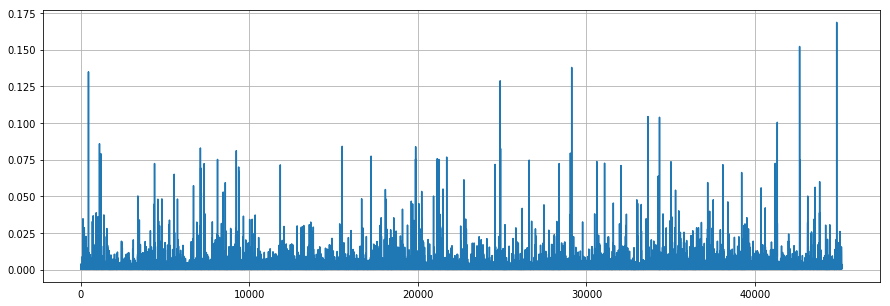

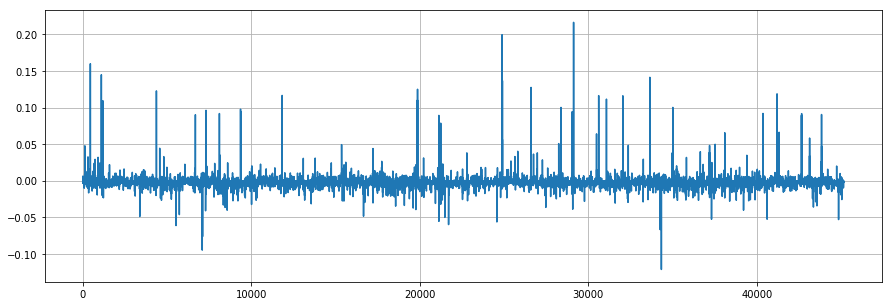

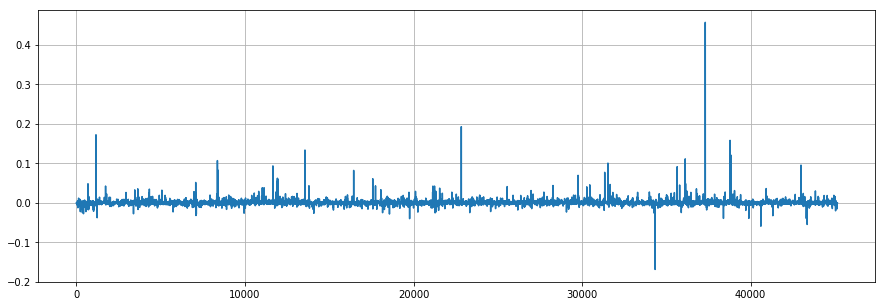

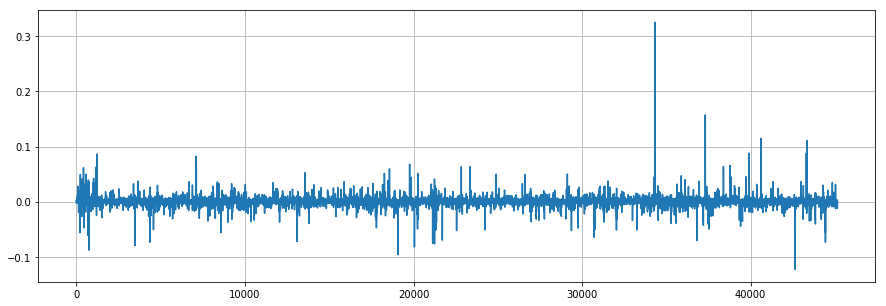

In [117]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(svd.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
    
    tmp = stub.copy()
    tmp[i] = 1
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.grid(True)

In [118]:
#LDA LSA + DIRICHIET
dictionary = corpora.Dictionary(corpus)

In [119]:
X_bow = [dictionary.doc2bow(text) for text in corpus]

In [120]:
lda_gensim = gensim.models.ldamodel.LdaModel(X_bow, num_topics=N_TOPICS, id2word=dictionary, iterations=10)

In [121]:
lda_gensim.print_topics()

[(0,
  '0.005*"это" + 0.002*"фото" + 0.002*"рублей" + 0.002*"которые" + 0.002*"года" + 0.002*"время" + 0.002*"году" + 0.002*"области" + 0.002*"также" + 0.002*"россии"'),
 (1,
  '0.006*"это" + 0.003*"рублей" + 0.002*"области" + 0.002*"года" + 0.002*"россии" + 0.002*"время" + 0.002*"фото" + 0.002*"году" + 0.002*"также" + 0.002*"которые"'),
 (2,
  '0.005*"это" + 0.003*"рублей" + 0.003*"года" + 0.002*"очень" + 0.002*"году" + 0.002*"также" + 0.002*"нижегородской" + 0.002*"фото" + 0.002*"время" + 0.002*"которые"'),
 (3,
  '0.005*"это" + 0.002*"рублей" + 0.002*"которые" + 0.002*"очень" + 0.002*"фото" + 0.002*"время" + 0.002*"нижегородской" + 0.002*"году" + 0.002*"россии" + 0.002*"дома"')]

In [98]:
N_TOPICS = [2, 3, 4, 5, 6, 7, 8, 9, 10]

In [99]:
#SKLEARN
for item in N_TOPICS:
    print("n topics = " + str(item))
    lda_sklearn = LatentDirichletAllocation(n_components=item, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

n topics = 2
iteration: 1 of max_iter: 10, perplexity: 119179.7106
iteration: 2 of max_iter: 10, perplexity: 112904.3845
iteration: 3 of max_iter: 10, perplexity: 106265.9005
iteration: 4 of max_iter: 10, perplexity: 102579.4041
iteration: 5 of max_iter: 10, perplexity: 101912.2228
iteration: 6 of max_iter: 10, perplexity: 101899.4725
iteration: 7 of max_iter: 10, perplexity: 101899.4439
n topics = 3
iteration: 1 of max_iter: 10, perplexity: 219068.7186
iteration: 2 of max_iter: 10, perplexity: 213016.7392
iteration: 3 of max_iter: 10, perplexity: 212304.5193
iteration: 4 of max_iter: 10, perplexity: 211546.6310
iteration: 5 of max_iter: 10, perplexity: 210870.4183
iteration: 6 of max_iter: 10, perplexity: 210777.1890
iteration: 7 of max_iter: 10, perplexity: 210667.8655
iteration: 8 of max_iter: 10, perplexity: 210361.3565
iteration: 9 of max_iter: 10, perplexity: 210000.5235
iteration: 10 of max_iter: 10, perplexity: 209168.4084
n topics = 4
iteration: 1 of max_iter: 10, perplexity: 

In [96]:
#SKLEARN
for item in N_TOPICS:
    print("n topics = " + str(item))
    lda_sklearn = LatentDirichletAllocation(n_components=item, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

n topics = 1
iteration: 1 of max_iter: 10, perplexity: 62447.3676
iteration: 2 of max_iter: 10, perplexity: 62447.3676
n topics = 5
iteration: 1 of max_iter: 10, perplexity: 709000.2518
iteration: 2 of max_iter: 10, perplexity: 694216.2036
iteration: 3 of max_iter: 10, perplexity: 690118.5796
iteration: 4 of max_iter: 10, perplexity: 687191.5528
iteration: 5 of max_iter: 10, perplexity: 684404.5857
iteration: 6 of max_iter: 10, perplexity: 678401.0930
iteration: 7 of max_iter: 10, perplexity: 667935.5096
iteration: 8 of max_iter: 10, perplexity: 650629.4249
iteration: 9 of max_iter: 10, perplexity: 613950.5924
iteration: 10 of max_iter: 10, perplexity: 536974.0417
n topics = 10
iteration: 1 of max_iter: 10, perplexity: 11372069.4684
iteration: 2 of max_iter: 10, perplexity: 10708198.3131
iteration: 3 of max_iter: 10, perplexity: 9798079.6294
iteration: 4 of max_iter: 10, perplexity: 8298240.3693
iteration: 5 of max_iter: 10, perplexity: 6644830.9266
iteration: 6 of max_iter: 10, perple

In [129]:
#SKLEARN
lda_sklearn = LatentDirichletAllocation(n_components=4, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X)

iteration: 1 of max_iter: 10, perplexity: 396473.0712
iteration: 2 of max_iter: 10, perplexity: 386641.1609
iteration: 3 of max_iter: 10, perplexity: 382378.8628
iteration: 4 of max_iter: 10, perplexity: 377301.8805
iteration: 5 of max_iter: 10, perplexity: 372686.3399
iteration: 6 of max_iter: 10, perplexity: 367011.0322
iteration: 7 of max_iter: 10, perplexity: 355356.0675
iteration: 8 of max_iter: 10, perplexity: 334156.7286
iteration: 9 of max_iter: 10, perplexity: 299946.3189
iteration: 10 of max_iter: 10, perplexity: 266831.5672


In [130]:
lda_sklearn.components_.shape

(4, 45148)

In [132]:
stub = [0] * 4

for i in range(4):
    ind = np.argsort(lda_sklearn.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
#     break

['bmw' 'стоимость' 'каток' 'января' 'году' 'улица' 'это' 'подробности'
 'часов' 'рублей']
[ 0.08408575  0.08587365  0.10047718  0.10393378  0.1044146   0.12880417
  0.13494586  0.13792002  0.15222147  0.16869862]

['парковки' 'году' 'области' 'правил' 'которые' 'рублей' 'news' 'года'
 'фото' 'это']
[ 0.11863163  0.12265564  0.12489764  0.12740194  0.13652965  0.14119258
  0.14467247  0.15970945  0.19936046  0.2162052 ]

['победы' 'halloween' 'атрибутов' 'магазине' 'область' 'кабы' 'бабы'
 'nokia' 'елка' 'мисс']
[ 0.11101801  0.12065967  0.13341392  0.14570616  0.15782388  0.17195522
  0.17538999  0.19253525  0.37929338  0.45651917]

['spacetour' 'ударилась' 'ледянке' 'подарок' 'призывник' 'призывников'
 'цирке' 'алексеевская' 'жюри' 'зрители']
[ 0.06798688  0.08239212  0.08624326  0.08783967  0.08798532  0.11097257
  0.11471143  0.13444789  0.1572293   0.32505912]

